In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import climlab
import xarray as xr
import scipy.integrate as sp  #Gives access to the ODE integration package
import pandas as pd
#https://climlab.readthedocs.io/en/latest/courseware/Spectral_OLR_with_RRTMG.html


In [2]:
atmosphere = pd.read_csv('input/midlatitude-summer.csv')

In [41]:
from climlab_rrtmg import rrtmg_lw, rrtmg_sw

def layer_average(df, var):
    data = df[var].to_numpy()/100.#[np.newaxis, ...]
    lyr_avg = (data[1:] + data[:-1])/2.
    print(var, lyr_avg)
    return lyr_avg[np.newaxis, ...]

# Specific heat at constant pressure
cp = 1004.

# RRTM code expects arrays with (ncol, nlay)
# and with pressure decreasing from surface at element 0
ncol = 1
nlay = atmosphere.shape[0] - 1
plev = atmosphere['p'].to_numpy()  # pressure bounds
play = (plev[1:] + plev[:-1])/2
play = play[np.newaxis, ...]
plev = plev[np.newaxis, ...]
# Set the temperatures
#  Using a linearly decreasing temperature from surface to TOA

temperature = atmosphere['t'].to_numpy()
tsfc = temperature[0]
tlev = temperature
tlay = (temperature[1:] + temperature[:-1])/2.
tlay = tlay[np.newaxis, ...]
tlev = tlev[np.newaxis, ...]

h2ovmr = layer_average(atmosphere, 'H2O')
o3vmr = layer_average(atmosphere, 'O3')
co2vmr = layer_average(atmosphere, 'CO2')
ch4vmr = layer_average(atmosphere, 'CH4')
n2ovmr = layer_average(atmosphere, 'N2O')
o2vmr = layer_average(atmosphere, 'O2')

#co2vmr = 348. / 1E6 * np.ones_like(play)
#ch4vmr = 1650. / 1E9 * np.ones_like(play)
#n2ovmr = 306. / 1E9 * np.ones_like(play)
#o2vmr = 0.21 * np.ones_like(play)

# Heavy molecules (chloroforocarbons)
cfc11vmr = 0. * np.ones_like(play)
cfc12vmr = 0. * np.ones_like(play)
cfc22vmr = 0. * np.ones_like(play)
ccl4vmr = 0. * np.ones_like(play)

#  Cloud parameters
cloud_level_index = 8
cldfrac = 0.5*np.exp(-(play-play[0,cloud_level_index])**2/(2*25.)**2)  # Layer cloud fraction: a Gaussian centered on a pressure level
clwp = 60. * np.ones_like(play)  # in-cloud liquid water path (g/m2)
ciwp = 0. * np.ones_like(play)   # in-cloud ice water path (g/m2)
relq = 14. * np.ones_like(play) # Cloud water drop effective radius (microns)
reic = 0. * np.ones_like(play)  # Cloud ice particle effective size (microns)

[[294.2   291.95  287.45  282.2   276.2   270.2   264.2   257.95  251.45
  244.95  238.5   232.05  225.55  219.05  215.75  215.7   215.7   215.7
  216.25  217.35  218.55  219.8   221.    222.2   223.35  224.5   226.775
  231.075 236.35  242.1   248.25  254.4   260.6   266.8   272.55  275.45
  272.5   263.2   248.6   229.1   207.1   185.1   169.6   165.05  171.65 ]] [[294.2  294.2  289.7  285.2  279.2  273.2  267.2  261.2  254.7  248.2
  241.7  235.3  228.8  222.3  215.8  215.7  215.7  215.7  215.7  216.8
  217.9  219.2  220.4  221.6  222.8  223.9  225.1  228.45 233.7  239.
  245.2  251.3  257.5  263.7  269.9  275.2  275.7  269.3  257.1  240.1
  218.1  196.1  174.1  165.1  165.   178.3 ]] [[1.100e+05 1.013e+05 9.020e+04 8.020e+04 7.100e+04 6.280e+04 5.540e+04
  4.870e+04 4.260e+04 3.720e+04 3.240e+04 2.810e+04 2.430e+04 2.090e+04
  1.790e+04 1.530e+04 1.300e+04 1.110e+04 9.500e+03 8.120e+03 6.950e+03
  5.950e+03 5.100e+03 4.370e+03 3.760e+03 3.220e+03 2.770e+03 1.907e+03
  1.320e+03 9.3

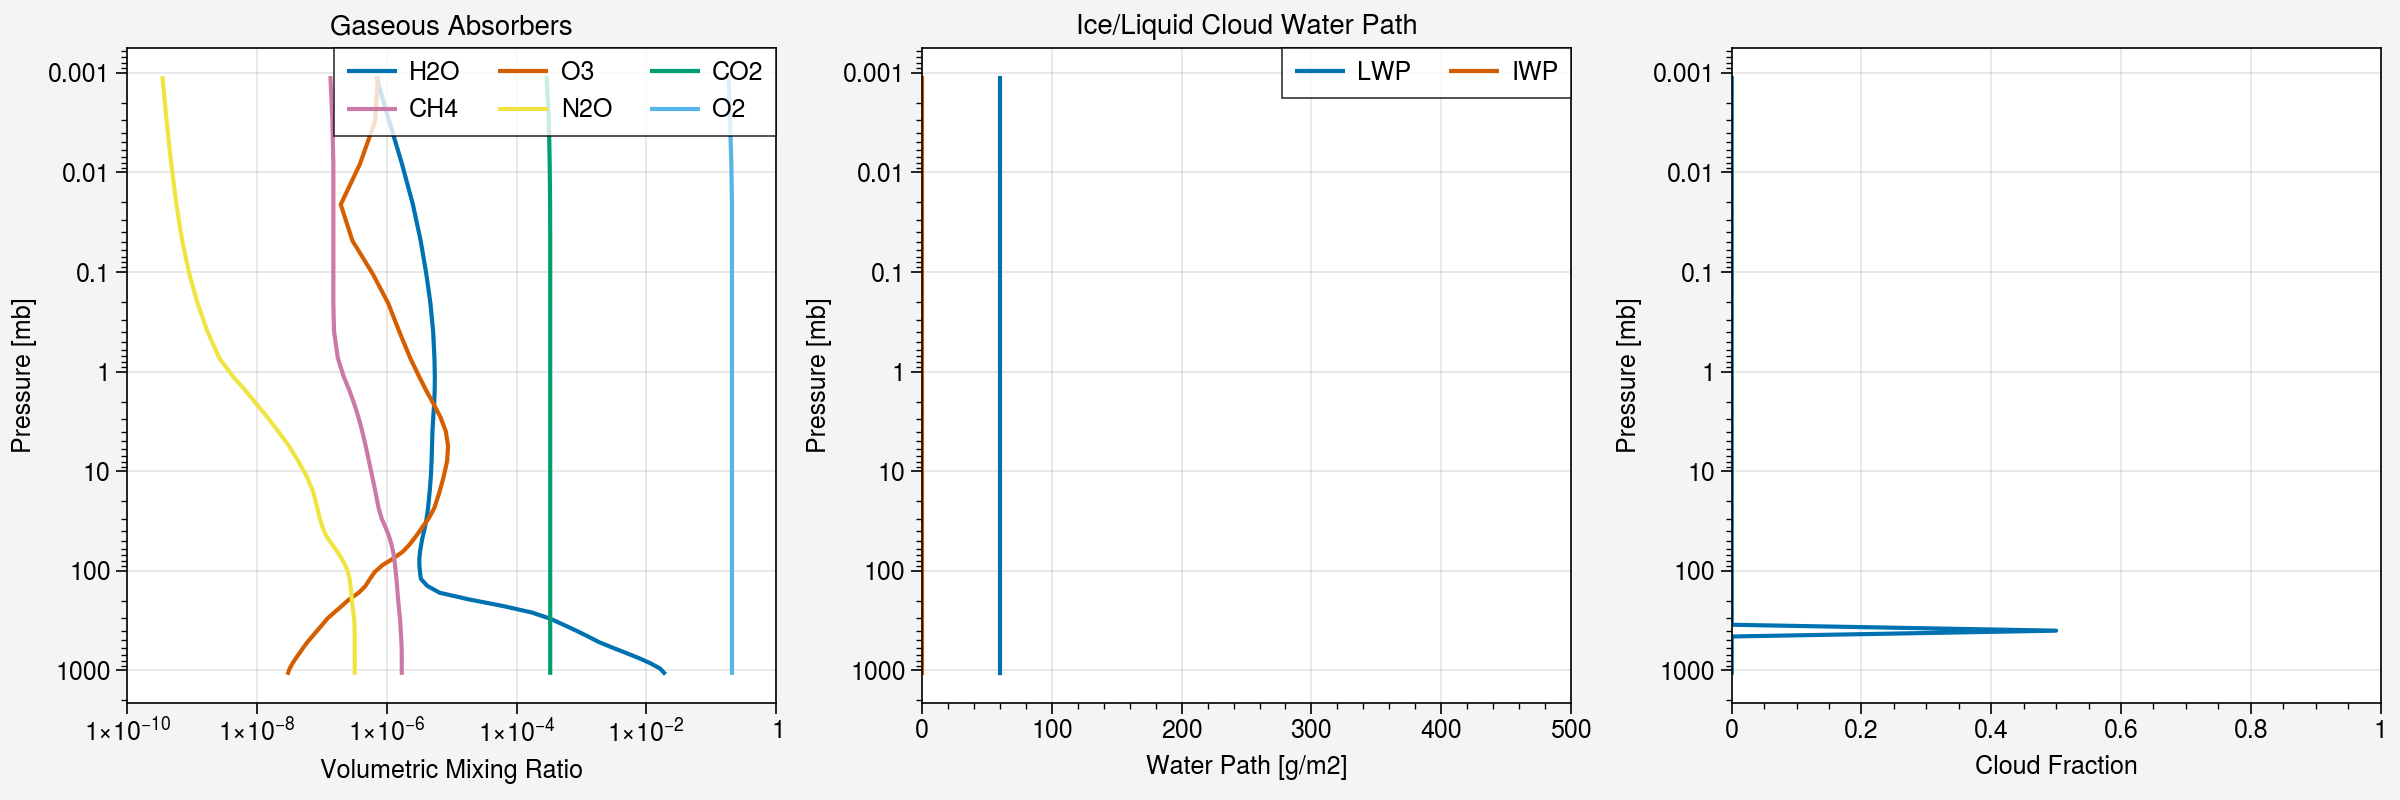

In [54]:
fig, axs = pplt.subplots(ncols=3, nrows=1, figsize=(12,4), sharex=False, sharey=False)
axs[0].plot(h2ovmr.squeeze(), play.squeeze()/100., label="H2O")
axs[0].plot(o3vmr.squeeze(), play.squeeze()/100., label="O3")
axs[0].plot(co2vmr.squeeze(), play.squeeze()/100., label="CO2")
axs[0].plot(ch4vmr.squeeze(), play.squeeze()/100., label="CH4")
axs[0].plot(n2ovmr.squeeze(), play.squeeze()/100., label="N2O")
axs[0].plot(o2vmr.squeeze(), play.squeeze()/100., label="O2")
axs[0].format(xscale='log', xlim=(1e-10,1), yscale='log', xformatter='sci', yreverse=True, ylabel="Pressure [mb]", xlabel="Volumetric Mixing Ratio", title="Gaseous Absorbers")
axs[0].legend()

axs[1].plot(clwp.squeeze(), play.squeeze()/100., label="LWP")
axs[1].plot(ciwp.squeeze(), play.squeeze()/100., label="IWP")

axs[1].format(yscale='log', yreverse=True, ylabel="Pressure [mb]", xlabel="Water Path [g/m2]", title="Ice/Liquid Cloud Water Path", xlim=(0,500))
axs[1].legend()

axs[2].plot(cldfrac.squeeze(), play.squeeze()/100.)
axs[2].format(yscale='log', yreverse=True, ylabel="Pressure [mb]", xlabel="Cloud Fraction", xlim=(0,1))
